# 1- importation des library et des modules utile 

In [1]:
import statistics
from scipy.stats import norm
import time
from random import Random
import numpy as np
import pandas as pd
from typing import Callable, Iterable
import itertools
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict   
#*** sklearn .**** 
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import umap.umap_ as umap  
#*************************
import models
from datasets import Datasets
from module_detection import ModuleDetection
from scores import Scores
from sklearn.manifold import TSNE
import matplotlib.patches as patches  # Import pour dessiner les cadres
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
#**********************
from node2vec import Node2Vec
#***********



/home/tchotan/virtual-env/multivue-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Définir les arguments sous forme d'un dictionnaire

args = {
    "number_of_runs": 1,
    "nb_modules": 1,
    "module_size": 10,
    "target_module_size": None,
    "network_size": 1000,
    "removed_edges": 0.0,
    "verbose": True,
    "outfile": None,
    "graph_generation": "guyon",  # Peut être modifié en "guyondata", "batra", "gencat"
    "param_k": 2,
    "param_mean_bg": 0,
    "param_mean_fg": 1,
    "metrique": "pearson",
    "param_std_fg": 1
}


# 2- fonction de base pour etudier comprendre les graphe 

### 2.1   fonction pour la densité

In [3]:
def calculer_densite(graph):
    densite = nx.density(graph)
    return densite


### 2.2   fonction pour affcicher le graphe avec les poids des arretes 

In [4]:
def plot_subgraph_with_weights(G, cluster_id, node_weight_attr='weight', offset=(0.05, -0.05)):
    """
    Affiche un sous-graphe du cluster spécifié avec les poids des nœuds affichés décalés.
    
    Args:
        G (nx.Graph): Graphe NetworkX.
        cluster_id: Identifiant du cluster à afficher.
        node_weight_attr (str): Nom de l'attribut contenant le poids des nœuds.
        offset (tuple): Décalage (x, y) à appliquer aux positions des labels de poids.
    """
    # Récupérer le dictionnaire des groupes
    groups = Datasets.get_groups(G)
    if cluster_id not in groups:
        print(f"Cluster {cluster_id} non trouvé dans les groupes.")
        return
    
    # Récupérer la liste des nœuds du cluster
    group = list(groups[cluster_id])
    
    # Créer le sous-graphe
    subgraph = G.subgraph(group)
    
    # Position des nœuds (avec un layout, ici spring_layout)
    pos = nx.spring_layout(subgraph)
    
    # Récupérer les labels des nœuds (noms)
    node_labels = {node: str(node) for node in subgraph.nodes}
    
    # Récupérer les poids et formater en label
    weight_labels = {node: f"{G.nodes[node].get(node_weight_attr, 0):.2f}" 
                     for node in subgraph.nodes}
    
    # Calculer des positions décalées pour les poids
    pos_offset = {node: (p[0] + offset[0], p[1] + offset[1]) for node, p in pos.items()}
    
    # Dessiner le sous-graphe avec les labels des nœuds
    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, pos, with_labels=True, labels=node_labels, node_color='lightblue',
            edge_color='gray', node_size=500)
    
    # Dessiner les poids décalés
    nx.draw_networkx_labels(subgraph, pos_offset, labels=weight_labels, font_color='red')
    
    plt.title(f"Sous-graphe du cluster {cluster_id} avec poids décalés")
    plt.show()




### 2.3   fonction pour dire si le graphe est complet ou pas 

In [5]:
def is_complete_subgraph(graph, subgraph_nodes):
    """
    Vérifie si le sous-graphe défini par 'subgraph_nodes' est complet.
    
    Args:
        graph (nx.Graph): Le graphe principal.
        subgraph_nodes (list): Liste des nœuds formant le sous-graphe.

    Returns:
        bool: True si le sous-graphe est complet, False sinon.

    Un graphe complet avec n nœuds doit avoir n(n-1)/2 arêtes
    """
    subgraph = graph.subgraph(subgraph_nodes)
    n = len(subgraph_nodes)
    
    return subgraph.number_of_edges() == (n * (n - 1)) // 2

# 3- contruction du  vues  ou des graphes 

### 3.1 - la premiere vue  

#### 3.1.1 - construction de la premiere vue

In [6]:

# Définition des paramètres de génération du graphe
P_PROB = 0.09
Q_PROB = 0.70
NB_INITIAL_NODES = 3


G = Datasets.get_scale_free_graph(args["network_size"],NB_INITIAL_NODES,args["nb_modules"], args["module_size"], P_PROB, Q_PROB, args["number_of_runs"],)
if args["removed_edges"] > 0:
    nbtoremove = int(G.number_of_edges() * args["removed_edges"])
    rng = Random(args["number_of_runs"],)
    edges_to_remove = rng.sample(list(G.edges), nbtoremove)
    G.remove_edges_from(edges_to_remove)
    G.graph["nb_edges"] = G.number_of_edges()

    

#### 3.1.2 - caracteristique de base de la premiere  vue

In [7]:
print(f"Graphe généré avec {G.number_of_nodes()} nœuds et {G.number_of_edges()} arêtes.")
print(f"le true hit {Datasets.get_groups(G)} ")
print(f"la densité du graphe est {calculer_densite(G)}")

Graphe généré avec 1000 nœuds et 4180 arêtes.
le true hit {1: {262, 491, 76, 205, 175, 628, 117, 373, 152, 92}} 
la densité du graphe est 0.008368368368368368


#### 3.1.3 - visualisation des  certains proprietes de la premiere vue

##### 3.1.3.1 - visualisation du groupe true hits

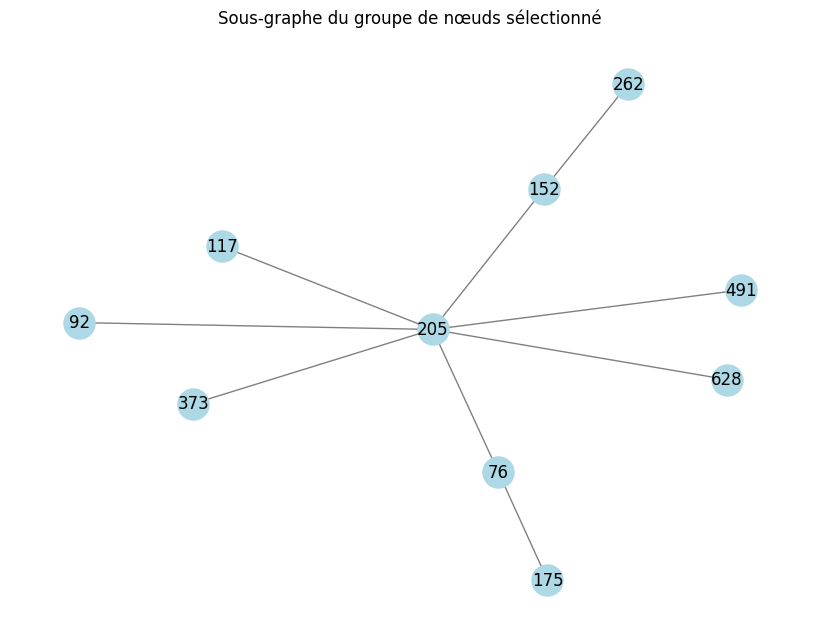

In [8]:

groupe_set=Datasets.get_groups(G)[1]
groupe_list = list(groupe_set)  # Remplacer identifiants de tes nœuds

# Créer un sous-graphe avec uniquement les nœuds spécifiés
subgraph = G.subgraph(groupe_list)

plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Sous-graphe du groupe de nœuds sélectionné")
plt.show()


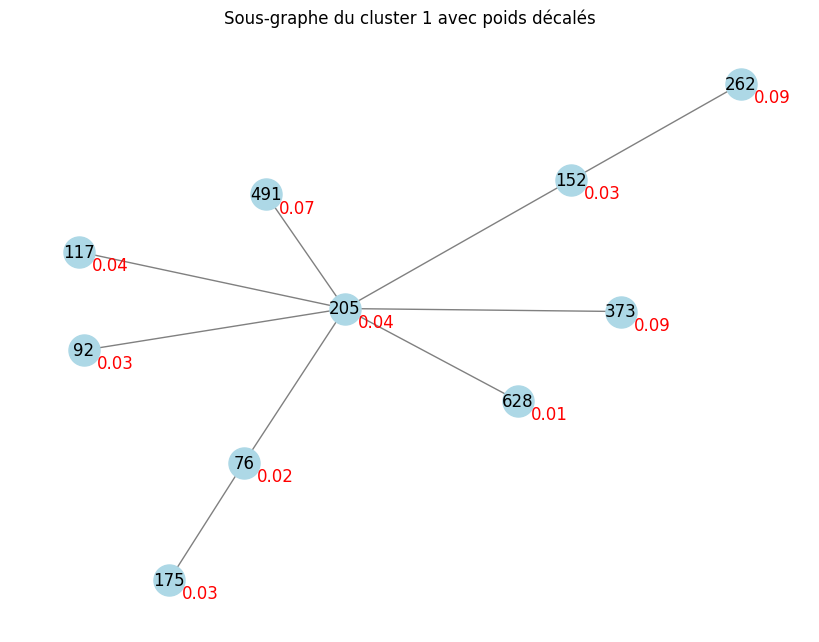

In [9]:
plot_subgraph_with_weights(G, cluster_id=1)


### 3.2 - la deuxieme vue ** Construction de la deuxieme a partir des poids 

#### 3.2.1 - la fonction de construction 

In [10]:
def build_similarity_graph(G, sigma=None, epsilon=0.95):
    """
    Construit un graphe basé sur la similarité des poids des nœuds.

    Paramètres:
    G (nx.Graph): Graphe d'origine avec les poids des nœuds.
    sigma (float): Paramètre de l'écart-type pour la fonction gaussienne.
    epsilon (float): Seuil de similarité pour créer les arêtes.

    Retourne:
    nx.Graph: Nouveau graphe construit à partir des similarités.
    """
    
    # Extraction des poids des nœuds
    node_weights = {node: data['weight'] for node, data in G.nodes(data=True)}
    nodes = list(G.nodes)

    # Calcul de sigma si non fourni
    if sigma is None:
        sigma = np.std(list(node_weights.values()))

    # Création du nouveau graphe
    new_G = nx.Graph()
    new_G.add_nodes_from(G.nodes(data=True))

    # Calcul de la similarité et ajout des arêtes
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            w_i = node_weights[nodes[i]]
            w_j = node_weights[nodes[j]]
            similarity = np.exp(-((w_i - w_j) ** 2) / (2 * sigma ** 2))
            
            if similarity >= epsilon:
                new_G.add_edge(nodes[i], nodes[j], weight=similarity)

    return new_G


#### 3.2.2 - appel de la fonction de construction 

In [11]:
view1=G
vue2 = build_similarity_graph(G)

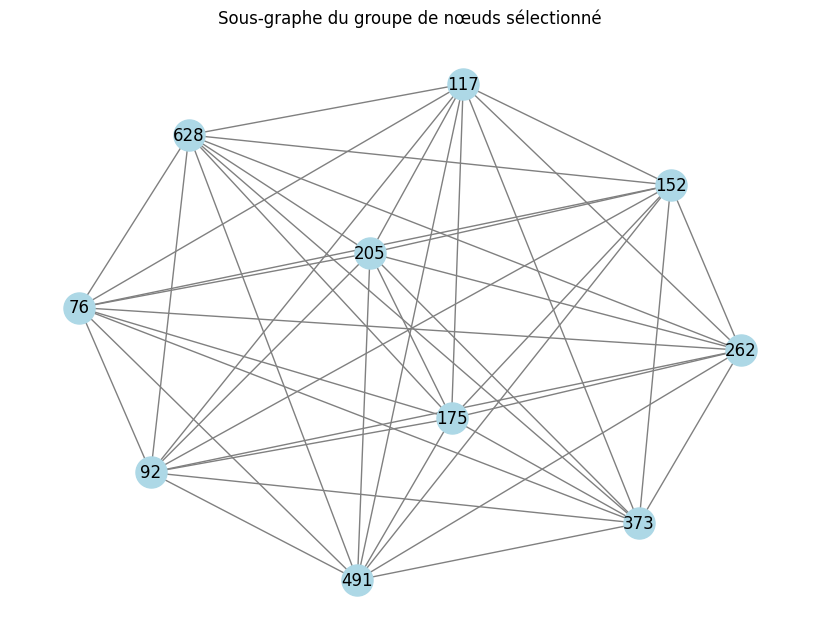

In [12]:
# Créer un sous-graphe avec uniquement les nœuds spécifiés
subgraph = vue2.subgraph(groupe_list)

plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Sous-graphe du groupe de nœuds sélectionné")
plt.show()


# 3. le modele d'embbedding 

### 3.1 model node2vec 

#### 3.1.1 Construction du model node2vec 

In [13]:

def create_node2vec_model(graph, dimensions=128, walk_length=40, num_walks=15, workers=4,p=0.5,q=1, window=10,weight_attr=None,):
    # Ajouter un attribut de poids si spécifié
    if weight_attr:
        for u, v, data in graph.edges(data=True):
            if weight_attr not in data:
                graph[u][v][weight_attr] = 1.0  # Ajouter un poids par défaut si absent

    # Génération des embeddings avec Node2Vec
    node2vec = Node2Vec( graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks,p=p,q=q, workers=workers, weight_key=weight_attr )
    model = node2vec.fit(window=window, min_count=1, batch_words=4,sg=1)

    # Récupérer les embeddings avec les labels (noms des nœuds)
    embeddings_with_etiquette = [
        [str(node)] + model.wv[str(node)].tolist()  # Concatène le nom du nœud avec ses vecteurs
        for node in graph.nodes()
    ]

    # Convertir en matrice NumPy (chaque ligne est un nœud avec son embedding)
    embeddings_array = np.array(embeddings_with_etiquette, dtype=object)  # Utilise 'object' pour mélanger chaînes et nombres
    return embeddings_array


#### 3.1.2 reduction ,fussion et projection de l'emmbedding  du model node2vec 

##### 3.1.2.1 la reduction  de l'emmbedding  du model node2vec 

In [14]:
def reduire_embeddings(data, method='pca', n_components=2, **kwargs):
    """
    Projette les embeddings en 2D ou 3D.
    
    Paramètres:
        data : numpy.ndarray, shape (n_samples, 1 + n_features)
            - Colonne 0 : labels
            - Colonnes 1+ : embeddings
        method : str, 'pca', 'tsne' ou 'umap'
        n_components : int, 2 ou 3
        **kwargs : paramètres additionnels pour la méthode choisie
    
    Retourne:
        X_proj : numpy.ndarray, shape (n_samples, n_components)
            Les embeddings projetés.
        labels : numpy.ndarray, shape (n_samples,)
            Les labels (convertis en str).
    """
    # Séparation des labels et des embeddings
    labels = data[:, 0].astype(str)
    embeddings = data[:, 1:].astype(float)
    
    # Choix du réducteur en fonction de la méthode
    if method == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, **kwargs)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, **kwargs)
    else:
        raise ValueError("Méthode non supportée : choisissez 'pca', 'tsne' ou 'umap'.")
    
    X_proj = reducer.fit_transform(embeddings)
    return X_proj, labels



##### 3.1.2.2 fonction  visualiser pour la reduction   

In [15]:

def visualiser_embedding(X_proj, labels, title="", target_nodes=None):
    """
    Affiche une projection 2D/3D des nœuds avec coloration personnalisée.

    Paramètres:
        X_proj (np.ndarray): Coordonnées projetées (shape [N, 2] ou [N, 3]).
        labels (list): Liste des étiquettes/identifiants des nœuds (taille N).
        title (str): Titre du graphique.
        target_nodes (list): Liste d'ÉTIQUETTES à colorer (ex: ["hub", "leaf"]).
    """
    # Validation des entrées
    labels = labels.ravel()  # Convertit shape (N, 1) → (N,)
    labels = labels.astype(str).tolist()  # Conversion en liste Python de strings
    target_nodes = [str(node) for node in target_nodes]
    missing = set(target_nodes) - set(labels)
    if missing:
        print(f"Étiquettes non trouvées : {missing}")
        
    assert len(labels) == X_proj.shape[0], "X_proj et labels doivent avoir le même nombre de nœuds."
    
    
    # Conversion des étiquettes cibles en indices
    target_indices = []
    if target_nodes is not None:
        # Étape 1: Trouver les indices correspondant aux étiquettes cibles
        target_indices = [i for i, lbl in enumerate(labels) if lbl in target_nodes]
        
        # Avertissement pour les étiquettes non trouvées
        found_labels = set(labels[i] for i in target_indices)
        missing = set(target_nodes) - found_labels
        if missing:
            print(f"[Avertissement] Étiquettes non trouvées: {missing}")

    # Création du tableau de couleurs
    if target_nodes is not None:
        # Étape 2: Colorer les nœuds cibles en rouge
        colors = ['red' if i in target_indices else 'lightgrey' for i in range(len(labels))]
        cmap = None
    else:
        # Colorer selon les étiquettes uniques
        _, label_indices = np.unique(labels, return_inverse=True)
        colors = label_indices
        cmap = 'viridis'

    # Configuration du plot
    plt.figure(figsize=(10, 8))
    
    # Cas 3D
    if X_proj.shape[1] == 3:
        ax = plt.axes(projection='3d')
        sc = ax.scatter(
            X_proj[:, 0], 
            X_proj[:, 1], 
            X_proj[:, 2], 
            c=colors, 
            cmap=cmap, 
            s=20, 
            alpha=0.8
        )
    # Cas 2D
    else:
        sc = plt.scatter(
            X_proj[:, 0], 
            X_proj[:, 1], 
            c=colors, 
            cmap=cmap, 
            s=20, 
            alpha=0.8
        )

    # Ajout de légendes
    if target_nodes is not None:
        plt.scatter([], [], c='red', label='Nœuds cibles')
        plt.legend()
    else:
        plt.colorbar(sc, label='Clusters')

    plt.title(title)
    plt.tight_layout()
    plt.show()

##### 3.1.2.3 fusionner les embbeding   

In [16]:
def merge_embeddings(emb1, emb2, method="concat", alpha=0.5):
    """
    Fusionne deux embeddings nodaux avec différentes méthodes de combinaison.

    Paramètres :
    emb1, emb2 : np.ndarray
        Arrays structurés avec forme (N, D+1) et (M, K+1)
        La première colonne contient les identifiants (type quelconque)
        Les colonnes suivantes contiennent les caractéristiques numériques
    method : str ("concat", "mean", "weighted")
        Méthode de fusion des caractéristiques
    alpha : float [0,1]
        Poids pour la combinaison linéaire (uniquement pour 'weighted')
    validate : bool
        Active les vérifications de cohérence des données

    Retourne :
    np.ndarray structuré avec colonnes ['id'] + caractéristiques combinées

    Exemple :
    >>> emb1 = np.array([["A", 1.0, 2.0], ["B", 3.0, 4.0]], dtype=object)
    >>> emb2 = np.array([["A", 5.0], ["B", 6.0]], dtype=object)
    >>> merge_embeddings(emb1, emb2, method="concat")
    array([['A', 1.0, 2.0, 5.0], ['B', 3.0, 4.0, 6.0]], dtype=object)
    """
    

    # Création de dictionnaires pour un accès rapide
    dict1 = {row[0]: row[1:].astype(np.float64) for row in emb1}
    dict2 = {row[0]: row[1:].astype(np.float64) for row in emb2}

    # Trouver les clés communes
    common_keys = sorted(set(dict1.keys()) & set(dict2.keys()))
    
    if not common_keys:
        return np.empty((0,), dtype=object)


    # Fusion des embeddings
    merged_data = []
    for key in common_keys:
        v1, v2 = dict1[key], dict2[key]
        
        if method == "concat":
            combined = np.concatenate([v1, v2])
        elif method == "mean":
            combined = (v1 + v2) / 2
        elif method == "weighted":
            combined = alpha * v1 + (1 - alpha) * v2
        else:
            raise ValueError(f"Méthode {method} non reconnue. Options: 'concat', 'mean', 'weighted'")

        merged_data.append(np.insert(combined, 0, key))

    # Construction du tableau de sortie
    return np.array(merged_data, dtype=object)

#### 3.1.2 utilisation  du model node2vec 

In [17]:
view1 = create_node2vec_model (G, dimensions=128, walk_length=80, num_walks=25,p=0.25,q=0.75,window=10, weight_attr=None)

Generating walks (CPU: 4): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


In [18]:
view2 = create_node2vec_model(vue2, dimensions=128, walk_length=80, num_walks=30,p=1,q=0.25, workers=4,window=10, weight_attr=None)

Generating walks (CPU: 4): 100%|██████████| 7/7 [00:23<00:00,  3.42s/it]


####  fusion des deux embbedding 

In [19]:
#vue_unifier=merge_embeddings(view1, view2, method="weighted", alpha=0.2) #Options: 'concat', 'mean', 'weighted'"

### 4 clustering sur les embbeding  realisé 

In [20]:
def evaluate_true_group(cluster_labels, node_names, true_group):
    """
    Évalue à quel cluster appartient le groupe de nœuds 'true_group'.

    Paramètres:
        cluster_labels : array-like, shape (n_samples,)
            Les labels attribués par l'algorithme de clustering pour chaque nœud.
        node_names : array-like, shape (n_samples,)
            La liste des noms (ou étiquettes) des nœuds correspondant aux éléments de cluster_labels.
        true_group : list or set
            Le groupe de nœuds dont on souhaite connaître l'appartenance.

    Retourne:
        best_cluster : le label du cluster qui contient le plus grand nombre d'éléments de true_group.
        overlap_score : la proportion d'éléments de true_group dans ce cluster.
        clusters_dict : dictionnaire {label: set(de nœuds)}
    """
    # Regrouper les nœuds par cluster
    clusters_dict = {}
    for node, label in zip(node_names, cluster_labels):
        clusters_dict.setdefault(label, set()).add(node)
    
    # true_group en set pour faciliter les calculs
    true_group_set = set(true_group)
    
    best_cluster = None
    best_overlap = 0
    
    for label, nodes in clusters_dict.items():
        intersection = nodes & true_group_set
        overlap = len(intersection) / len(true_group_set)  # proportion de true_group présente dans ce cluster
       # print(f"Cluster {label} contient {len(intersection)} éléments de true_group ({overlap*100:.1f}%).")
        if overlap > best_overlap:
            best_overlap = overlap
            best_cluster = label
            
    return best_cluster, best_overlap, clusters_dict


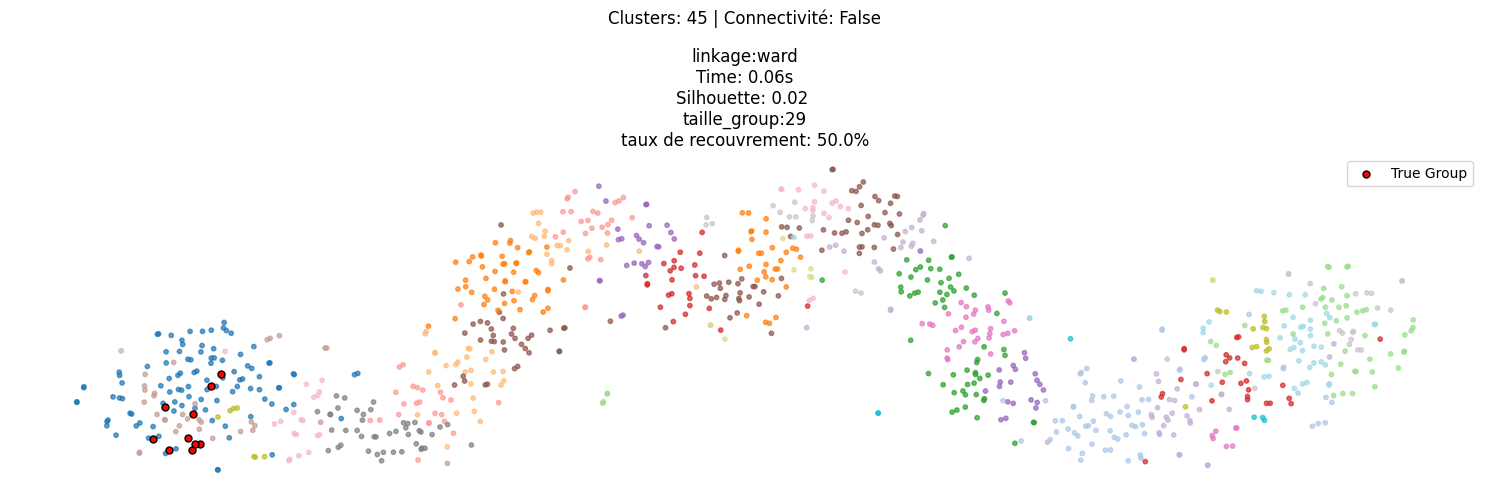

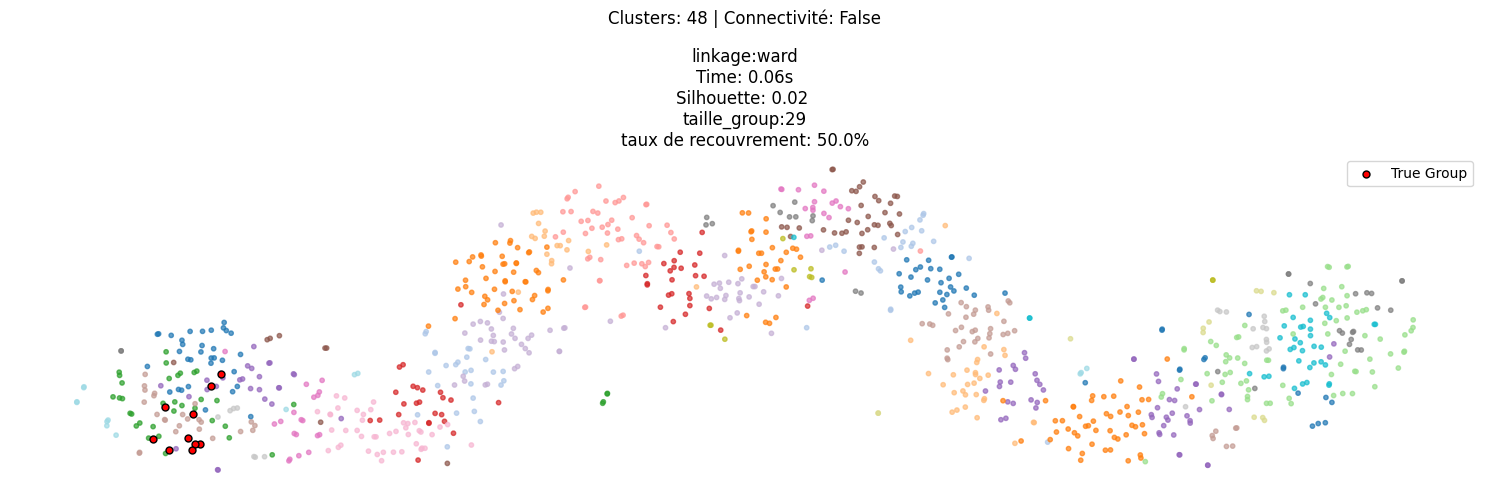

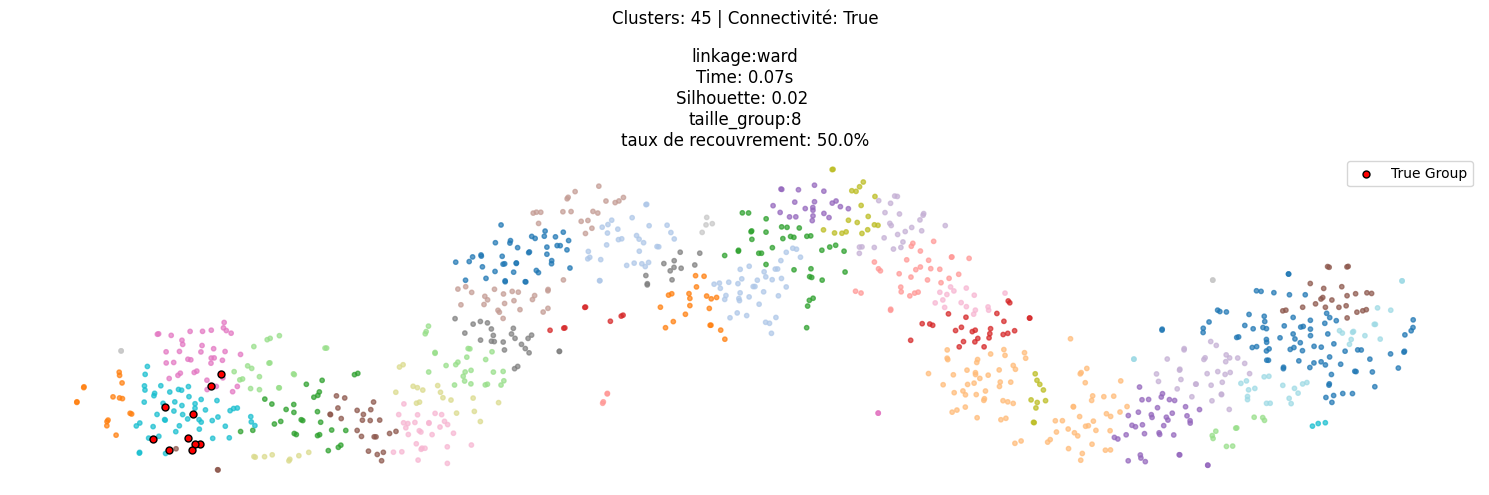

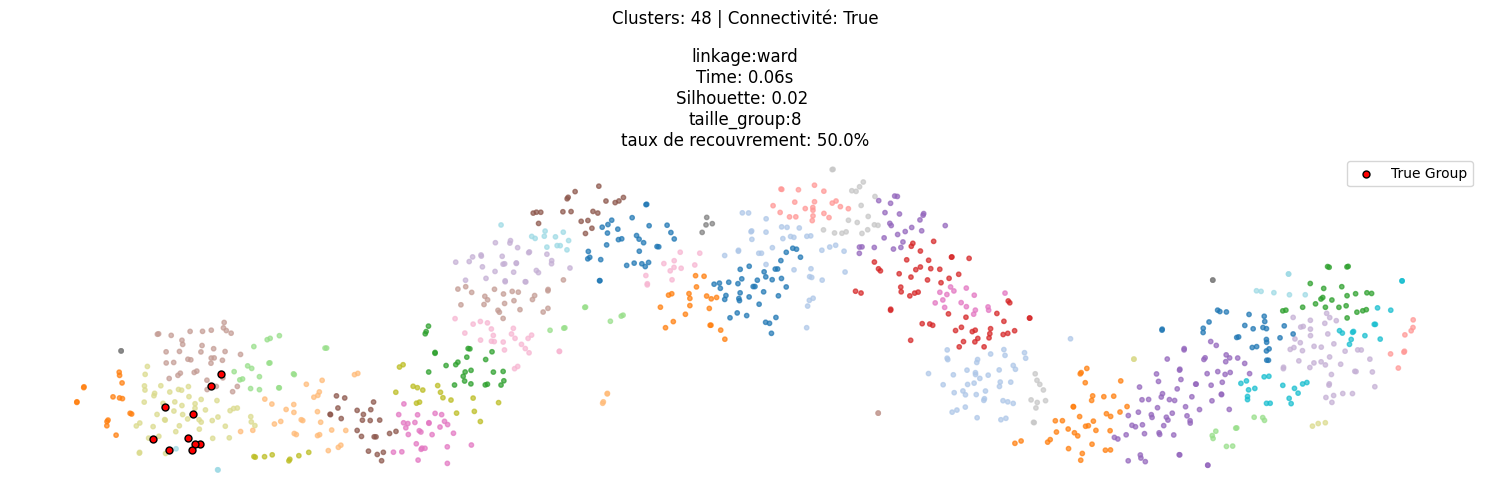

In [21]:

scaler = StandardScaler()
vue_unifier=merge_embeddings(view1, view2, method="weighted", alpha=0.26467) #Options: 'concat', 'mean', 'weighted'"
#groupe=Datasets.get_groups(G)[1]

target_nodes=groupe_list
#target_nodes = [int(node) for node in target_nodes]
# Préparation des données
#node_etiquette = vue_unifier[:, 0].astype(int)
node_etiquette = np.array([int(float(x)) for x in vue_unifier[:, 0]])
#print(node_etiquette )
X_features =StandardScaler().fit_transform(vue_unifier[:, 1:].astype(float) ) #

# Projection t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
X_proj = tsne.fit_transform(X_features)

#X_proj, labels_umap2= project_embeddings(embeddings_vue2, method='umap', n_components=2, n_neighbors=6)


# Création du graphe de connectivité
knn_graph = kneighbors_graph(X_proj , n_neighbors=4, include_self=False)

# Paramètres à tester
params = {
    'n_clusters': [45,48],
    'connectivity': [None, knn_graph],
    'linkage': ['ward']
}

# Grid search visuelle
for connectivity in params['connectivity']:
    for n_clusters in params['n_clusters']:
        

        plt.figure(figsize=(15, 5))
        
        for idx, linkage in enumerate(params['linkage']):

            # Clustering
            start = time.time()
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, connectivity=connectivity ).fit(X_features)
            
            # Calcul métrique
            elapsed = time.time() - start
            best_cluster, best_overlap, clusters_dict = evaluate_true_group(model.labels_, node_etiquette , target_nodes)
            score = silhouette_score(X_features, model.labels_)  

            # Visualisation
            plt.subplot(1, len(params['linkage']), idx+1)
            scatter = plt.scatter(
                X_proj[:, 0], X_proj[:, 1],
                c=model.labels_,
                cmap='tab20',
                s=10,
                alpha=0.7
            )
              # Identifier les indices des nœuds du true_group
            true_group_indices = [i for i, node in enumerate(node_etiquette) if node in target_nodes]

            # Ajouter les nœuds du true_group avec un style distinctif
            plt.scatter(
                X_proj[true_group_indices, 0],  # Coordonnées X en t-SNE
                X_proj[true_group_indices, 1],  # Coordonnées Y en t-SNE
                c='red',                        # Couleur rouge pour les démarquer
                edgecolors='black',             # Contour noir
                marker='.',                     # Symbole étoile pour plus de visibilité
                s=100,                           # Taille plus grande
                label="True Group"               # Légende
            )
             # Ajouter un cadre autour de chaque sous-figure
            if best_cluster is not None:

                plt.title(f"linkage:{linkage}\nTime: {elapsed:.2f}s\nSilhouette: {score:.2f} \ntaille_group:{len(clusters_dict[best_cluster])}\ntaux de recouvrement: {best_overlap*100:.1f}%")
            else :
               plt.gca().set_title("Aucun cluster trouvé")
            plt.legend()  # Ajout de la légende
            plt.axis('off')
        
        plt.suptitle(f"Clusters: {n_clusters} | Connectivité: {connectivity is not None}")    
        plt.tight_layout()
        plt.show()

#### 3.2 model GAT

### generation aleatoire du graphe 